In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_local')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head()

test N: 106,336
training + validation N: 424,401


,set,input_ct,selected_ct,y,x
0,training,73.0,62.0,-1.021847,QYKLILNGKTLKGETTTEAHDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,122.0,0.0,-7.732188,QYKLILNGKTLKGETTTEAVDAATAEKVFPQYANDNGVDGEWTYDD...
2,training,794.0,598.0,-1.198072,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANKNGVDGEWTLDD...
3,training,1115.0,595.0,-1.694626,QYKLILNIKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDS...
4,validation,97.0,2.0,-5.819421,QYKLINNGKTLKGETTTEAVDAATAEKVFKIYANDNGVDGEWTYDD...


In [4]:
# Comptue sequence length and number of bins
L = len(data_df['x'][0])

In [5]:
from mavenn.src.layers.gpmap import CustomGPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(CustomGPMapLayer):
    """
    Represents a three stage thermodynamic model
    containing the states:
    1. Unfolded and unbound
    2. Folded and unbound
    3. Folded and bound.
    """

    def __init__(self, 
                 L,
                 C,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.L = L
        self.C= C
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        # define bias/chemical potential weight for folding energy
        self.mu_f = self.add_weight(name='mu_f',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)

        # define bias/chemical potential weight for binding energy
        self.mu_b = self.add_weight(name='mu_b',
                                       shape=(1,),
                                       initializer=Constant(1.),
                                       trainable=True,
                                       regularizer=self.regularizer)


        # Define theta_binding_lc parameters
        theta_b_lc_shape = (1, self.L, self.C)

        theta_b_lc_init = np.random.randn(*theta_b_lc_shape)/np.sqrt(self.L)
        self.theta_b_lc = self.add_weight(name='theta_b_lc',
                                        shape=theta_b_lc_shape,
                                        initializer=Constant(theta_b_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)
        
        # Define theta_folding_lc parameters
        theta_f_lc_shape = (1, self.L, self.C)

        theta_f_lc_init = np.random.randn(*theta_f_lc_shape)/np.sqrt(self.L)
        self.theta_f_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_f_lc_shape,
                                        initializer=Constant(theta_f_lc_init),
                                        trainable=True,
                                        regularizer=self.regularizer)

        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # reshape sequence to samples x length x characters
        x_lc = tf.reshape(x_lc, [-1, self.L, self.C])
        
        # compute delta G for binding    
        G_b = self.mu_b + \
              tf.reshape(K.sum(self.theta_b_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for rnap
        G_f = self.mu_f + \
              tf.reshape(K.sum(self.theta_f_lc * x_lc, axis=[1, 2]),
                         shape=[-1, 1])            
        
        # compute p_fb
        p_fb = (K.exp(-G_f-G_b))/(1+K.exp(-G_f)+K.exp(-G_f-G_b))
        
        # return rate of transcription
        return p_fb


In [10]:
# define custom gp_map parameters dictionary
gpmap_kwargs = {'L':L,
                'C':20,
                'regularizer':0.01}

# Create model
model = mavenn.Model(L=L, 
                     alphabet='protein', 
                     regression_type='GE', 
                     gpmap_type='custom',
                     #ge_nonlinearity_type='linear',
                     gpmap_kwargs=gpmap_kwargs,
                     custom_gpmap=ThermodynamicLayer)

In [11]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               validation_flags=(data_df['set']=='validation'),
               shuffle=True)

# Fit model to data
model.fit(learning_rate=.001,
          epochs=1000,
          batch_size=100,
          early_stopping=True,
          early_stopping_patience=25,
          linear_initialization=True)


N = 424,401 observations set as training data.
Using 24.9% for validation.
Data shuffled.
Time to set data: 24.3 sec.
Epoch 1/1000
3188/3188 [==============================] - 14s 4ms/step - loss: 78.5065 - I_var: 1.2480 - val_loss: 14.5602 - val_I_var: 1.6205
Epoch 2/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 14.5233 - I_var: 1.6266 - val_loss: 12.4237 - val_I_var: 1.6459
Epoch 3/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 12.6000 - I_var: 1.6477 - val_loss: 11.7129 - val_I_var: 1.6545
Epoch 4/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 10.9955 - I_var: 1.6660 - val_loss: 9.9651 - val_I_var: 1.6813
Epoch 5/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 9.8741 - I_var: 1.6815 - val_loss: 10.9377 - val_I_var: 1.6696
Epoch 6/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 9.3855 - I_var: 1.6919 - val_loss: 10.5308 - val_I_var: 1.6781
Epoch 7/1000
3188/3188 [========

Epoch 58/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.4178 - I_var: 1.7233 - val_loss: 6.0522 - val_I_var: 1.7272
Epoch 59/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.3068 - I_var: 1.7233 - val_loss: 7.6318 - val_I_var: 1.7043
Epoch 60/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.2606 - I_var: 1.7236 - val_loss: 7.4123 - val_I_var: 1.7075
Epoch 61/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.3796 - I_var: 1.7234 - val_loss: 6.1036 - val_I_var: 1.7263
Epoch 62/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.1257 - I_var: 1.7235 - val_loss: 5.7448 - val_I_var: 1.7314
Epoch 63/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.4735 - I_var: 1.7236 - val_loss: 5.9743 - val_I_var: 1.7278
Epoch 64/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.2505 - I_var: 1.7248 - val_loss: 5.7705 - val_I_var: 1.7307
Epoch 65/1000

Epoch 116/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 5.8446 - I_var: 1.7251 - val_loss: 8.0720 - val_I_var: 1.6951
Epoch 117/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 5.6848 - I_var: 1.7252 - val_loss: 5.8245 - val_I_var: 1.7275
Epoch 118/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 5.6604 - I_var: 1.7242 - val_loss: 8.5615 - val_I_var: 1.6880
Epoch 119/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 5.8792 - I_var: 1.7250 - val_loss: 5.6111 - val_I_var: 1.7306
Epoch 120/1000
3188/3188 [==============================] - 9s 3ms/step - loss: 5.7822 - I_var: 1.7247 - val_loss: 7.1548 - val_I_var: 1.7085
Epoch 121/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.1364 - I_var: 1.7259 - val_loss: 9.4180 - val_I_var: 1.6758
Epoch 122/1000
3188/3188 [==============================] - 8s 3ms/step - loss: 6.1477 - I_var: 1.7251 - val_loss: 5.7386 - val_I_var: 1.7287
Epoch 

3188/3188 [==============================] - 7s 2ms/step - loss: 2.2587 - I_var: 1.8021 - val_loss: 1.8682 - val_I_var: 1.8089
Epoch 174/1000
3188/3188 [==============================] - 7s 2ms/step - loss: 2.1960 - I_var: 1.8039 - val_loss: 1.7653 - val_I_var: 1.8108
Epoch 175/1000
3188/3188 [==============================] - 7s 2ms/step - loss: 2.0279 - I_var: 1.8064 - val_loss: 3.4045 - val_I_var: 1.7874
Epoch 176/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 1.7113 - I_var: 1.8079 - val_loss: 1.4854 - val_I_var: 1.8157
Epoch 177/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 1.9651 - I_var: 1.8100 - val_loss: 2.0764 - val_I_var: 1.8073
Epoch 178/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 2.2201 - I_var: 1.8108 - val_loss: 1.4400 - val_I_var: 1.8167
Epoch 179/1000
3188/3188 [==============================] - 7s 2ms/step - loss: 2.0398 - I_var: 1.8117 - val_loss: 1.2654 - val_I_var: 1.8193
Epoch 180/1000
3188/3

Epoch 231/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 0.5325 - I_var: 1.8282 - val_loss: 1.8165 - val_I_var: 1.8134
Epoch 232/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 0.5074 - I_var: 1.8277 - val_loss: 0.6950 - val_I_var: 1.8296
Epoch 233/1000
3188/3188 [==============================] - 7s 2ms/step - loss: 0.5855 - I_var: 1.8281 - val_loss: 1.1696 - val_I_var: 1.8227
Epoch 234/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 0.3904 - I_var: 1.8275 - val_loss: 1.2293 - val_I_var: 1.8218
Epoch 235/1000
3188/3188 [==============================] - 7s 2ms/step - loss: 0.4073 - I_var: 1.8271 - val_loss: 0.4365 - val_I_var: 1.8332
Epoch 236/1000
3188/3188 [==============================] - 8s 2ms/step - loss: 0.7931 - I_var: 1.8272 - val_loss: 1.9335 - val_I_var: 1.8117
Epoch 237/1000
3188/3188 [==============================] - 7s 2ms/step - loss: 0.4772 - I_var: 1.8282 - val_loss: 0.5313 - val_I_var: 1.8318
Epoch 

On test data:
I_var_test: 1.852 +- 0.012 bits
I_pred_test: 2.247 +- 0.003 bits


Text(0.5, 1.0, 'training hisotry')

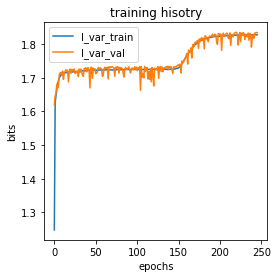

In [12]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df['y'].values

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
#ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
#ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

In [38]:
# Subsample indices for easy plotting and information estimation
N_test = len(test_df)
ix = np.random.rand(N_test) < .2

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

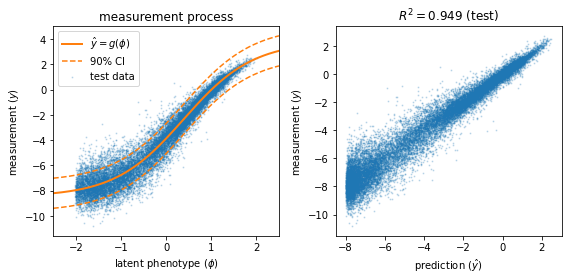

In [41]:
# Compute phi and yhat values
phi = model.x_to_phi(x_test)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-2.5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
#yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.05,.95])

# Create two panels
fig, ax = plt.subplots(1, 2, figsize=[8, 4])

# Illustrate measurement process with GE curve
ax[0].scatter(phi, y_test, color='C0', s=1, alpha=.2, label='test data')
ax[0].plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax[0].plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='90% CI')
ax[0].plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax[0].set_xlim(phi_lim)
ax[0].set_xlabel('latent phenotype ($\phi$)')
ax[0].set_ylabel('measurement ($y$)')
ax[0].set_title('measurement process')
ax[0].legend()

Rsq = np.corrcoef(yhat,y_test)[0][1]**2
ax[1].scatter(yhat, y_test, color='C0', s=1, alpha=.2, label='test data')
ax[1].set_xlabel('prediction ($\hat{y}$)')
ax[1].set_ylabel('measurement ($y$)')
ax[1].set_title(f'$R^2 = ${Rsq:.3f} (test)')

# Fix up plot
fig.tight_layout()
plt.show()

In [65]:
theta_binding_lc = model.get_nn().layers[2].get_weights()[2][0]
theta_folding_lc = model.get_nn().layers[2].get_weights()[3][0]
theta_0_f = model.get_nn().layers[2].get_weights()[0][0]
theta_0_b = model.get_nn().layers[2].get_weights()[1][0]

In [74]:
from mavenn.src.utils import _x_to_mat

# Code taken from mavenn model.get_theta
def fix_theta_wt_gauge(theta_lc,
                       theta_0,
                       L,
                       C,
                       consensus_seq,
                       alphabet):

    p_lc = _x_to_mat(consensus_seq, alphabet)

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]    
        
    return fixed_theta_0, fixed_theta_lc


In [75]:
# fix_theta_wt_gauge(theta_binding_lc, 
#                    theta_0_b)
gb1_seq = model.x_stats['consensus_seq']

theta_0_b_gf, theta_binding_lc_gf = fix_theta_wt_gauge(theta_binding_lc, 
                                                       theta_0_b,
                                                       L,
                                                       model.C,
                                                       gb1_seq,
                                                       model.alphabet)

theta_0_f_gf, theta_folding_lc_gf = fix_theta_wt_gauge(theta_folding_lc, 
                                                       theta_0_f,
                                                       L,
                                                       model.C,
                                                       gb1_seq,
                                                       model.alphabet)

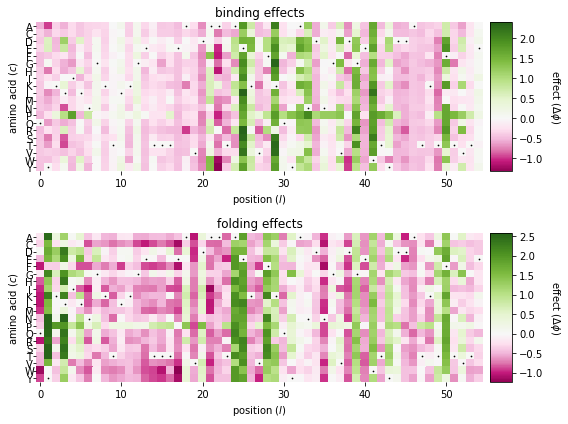

In [76]:
# Set wild-type sequence
gb1_seq = model.x_stats['consensus_seq']

# Get effects of all single-point mutations on phi
# theta_dict = model.get_theta(gauge='user',
#                              x_wt=gb1_seq)

# Create two panels
fig, ax = plt.subplots(2, 1, figsize=[8, 6])

# Left panel: draw heatmap illustrating 1pt mutation effects
ax[0], cb = mavenn.heatmap(theta_binding_lc_gf,
                        alphabet='protein',
                        seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax[0])
ax[0].set_xlabel('position ($l$)')
ax[0].set_ylabel('amino acid ($c$)')
cb.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax[0].set_title('binding effects')


# Left panel: draw heatmap illustrating 1pt mutation effects
ax[1], cb1 = mavenn.heatmap(theta_folding_lc_gf,
                        alphabet='protein',
                        seq=gb1_seq,
                        cmap='PiYG',
                        ccenter=0,
                        ax=ax[1])
ax[1].set_xlabel('position ($l$)')
ax[1].set_ylabel('amino acid ($c$)')
cb1.set_label('effect ($\Delta\phi$)', rotation=-90, va="bottom")
ax[1].set_title('folding effects')

# Fix up plot
fig.tight_layout()
fig.savefig('binding_folding_theta_gf.png',bbox_inches='tight',dpi=200)
plt.show()

In [87]:
# theta_binding_df = pd.DataFrame(theta_binding_lc_gf,columns=model.alphabet)
# theta_folding_df = pd.DataFrame(theta_folding_lc_gf,columns=model.alphabet)
# jakub_columns_order = ['K','R','H','E','D','N','Q','T','S','C','G','A','V','L','I','M','P','Y','F','W']

In [100]:
# import seaborn as sns

# fig, ax = plt.subplots(2, 1, figsize=[12, 10])

# ax[0] = sns.heatmap(theta_binding_df[jakub_columns_order].T, ax=ax[0], cmap='PiYG')
# ax[1] = sns.heatmap(theta_folding_df[jakub_columns_order].T, ax=ax[1], cmap='PiYG')

In [101]:
model.save('thermodynamic_3_state_gb1')

Model saved to these files:
	thermodynamic_3_state_gb1.pickle
	thermodynamic_3_state_gb1.h5
